In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

# Feature Engineering

### Method 1 Grouping and find Common Factors

<AxesSubplot:xlabel='timestamp'>

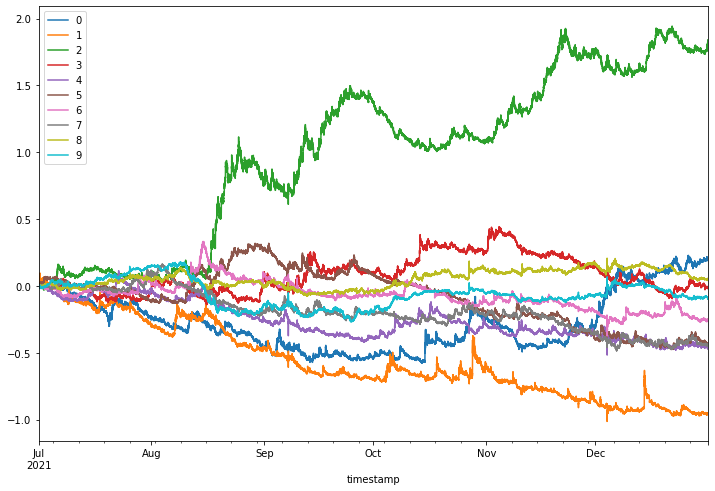

In [42]:
log_pr.plot(figsize=(12,8))

Text(0.5, 1.0, 'Correlation Heatmap for Log Prices')

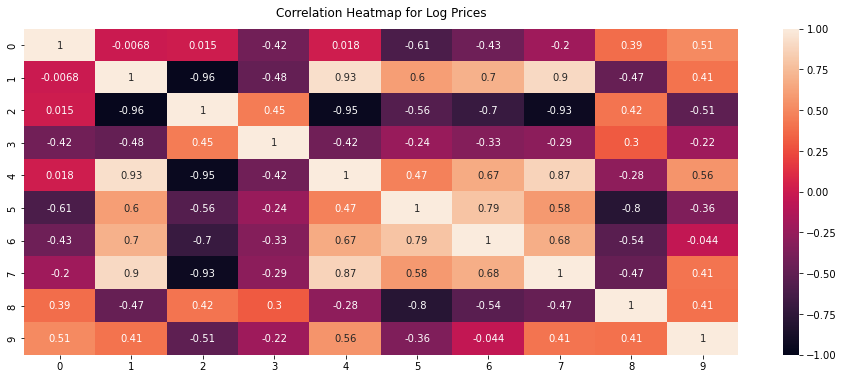

In [40]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(log_pr.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for Log Prices', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Correlation Heatmap for Volume')

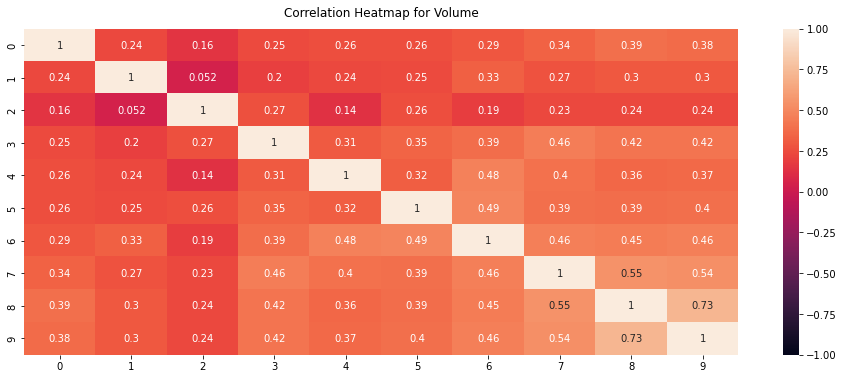

In [41]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(volu.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for Volume', fontdict={'fontsize':12}, pad=12)

According to log price and two heatmap, reasonable grouping would be: 0,3,(1,2,4,7),(8,9),(5,6)

### Method 2 Do a whole PCA on the ten stocks

In [70]:
log_pr_10.shape

(26496, 10)

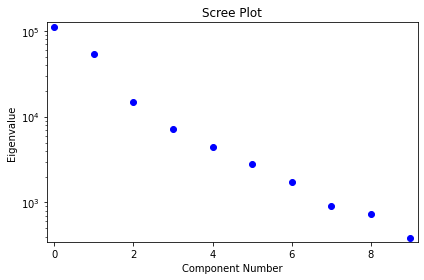

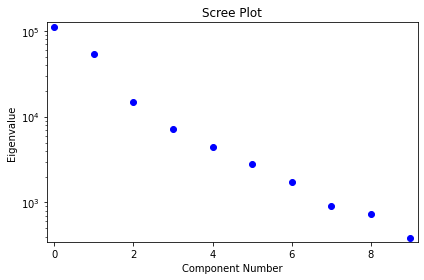

In [72]:
log_pr_10 = log_pr.resample("10T").mean()

from statsmodels.multivariate.pca import PCA
log_pr_10_pca = PCA(log_pr_10.iloc[:20000],)
log_pr_10_pca.plot_scree(log_scale=True)

In [73]:
log_pr_10_pca.eigenvals.cumsum()/log_pr_10_pca.eigenvals.sum()

0    0.563121
1    0.836036
2    0.909520
3    0.945042
4    0.967280
5    0.981271
6    0.989932
7    0.994420
8    0.998055
9    1.000000
Name: eigenvals, dtype: float64

In [106]:
pca_loadings = (log_pr_10_pca.coeff.to_numpy()[:3]).T
pca_loadings.shape

(10, 3)

Use 3-4 PCs

In [107]:
np_pr = log_pr.to_numpy()
prpc = np_pr @ pca_loadings
(prpc@pca_loadings.T).shape

(264960, 10)

# Modelling

In [112]:
# Data transformation
# perform transformation on three pcs respectively
pc1 = prpc[:,0] # (264960,)=(1440x184,)
pc2 = prpc[:,1]
pc3 = prpc[:,2]

def data_partition(dta):
    '''
    Partition the data into observation of sliding window of 1440 min, and the list of 30 mins forward returns
    '''
    pt_dtax = np.empty((4391,1440))
    pt_dtay = np.empty((4391,))
    for i in range(4391):
        idx1 = 60 * i
        idx2 = 1440 + 60 * i
        pt_dtax[i] = dta[idx1:idx2]
        idx_y = 1470 + 60 * i
        pt_dtay[i] = dta[idx_y]
    return pt_dtax,pt_dtay

x1,y1 = data_partition(pc1)
x2,y2 = data_partition(pc2)
x3,y3 = data_partition(pc3)

In [129]:
from sklearn.neural_network import MLPRegressor

X0_train, X0_test, y0_train, y0_test = train_test_split(x1, y1,test_size=0.2,random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X0_train, y0_train)
regr.score(X0_test,y0_test)
#regr1 = MLPRegressor(hidden_layer_size=(100,10),random_state=1, max_iter=500).fit(x1,y1)
#regr2 = MLPRegressor(random_state=1, max_iter=500).fit(x2,y2)
#regr3 = MLPRegressor(random_state=1, max_iter=500).fit(x3,y3)


0.9982846146369486

In [125]:
#from mlpregressor import pca_loadings,regr1,regr2,regr3

A = log_pr.iloc[60:1500,:]

#def get_r_hat(A):
#Apc = (A@pca_loadings)
#y1pred = regr1.predict(Apc[0])
#y2pred = regr2.predict(Apc[1])
#y3pred = regr3.predict(Apc[2])
#ypc = np.hstack((y1pred,y2pred,y3pred))
#ypred = (ypc@pca_loadings.T).flatten()
#return ypred

Apc = (A.to_numpy()@pca_loadings).T
y1pred = regr1.predict(Apc[0].reshape(1,1440))
y2pred = regr2.predict(Apc[1].reshape(1,1440))
y3pred = regr3.predict(Apc[2].reshape(1,1440))
ypc = np.hstack((y1pred,y2pred,y3pred))
ypred = (ypc@pca_loadings.T).flatten()
ypred

array([ 519.68907853,  800.74020305, -739.88400723, -837.78303176,
        669.68203744,  476.42651061,  522.04817122,  674.81730337,
       -494.08921127,  256.3190358 ])

In [127]:
log_pr.iloc[1530,:]

0   -0.011165
1    0.030307
2   -0.011537
3   -0.005796
4    0.010774
5    0.023816
6   -0.012885
7    0.004273
8   -0.005118
9   -0.010065
Name: 2021-07-02 01:30:00, dtype: float64

In [37]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X0_train, X0_test, y0_train, y0_test = train_test_split(pt0x, pt0y,test_size=0.2,random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X0_train, y0_train)
regr.score(X0_test,y0_test)

0.989799405871144

In [105]:
regr.predict(X0_test[0].reshape(1,1440))

array([0.04279871])

In [111]:
np.vstack((np.array([1,2]),np.array([1,2])))

array([[1, 2],
       [1, 2]])